# Titanic Dataset

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Preprocessing

### Cleaning

In [19]:
titanic = pd.read_csv("data/train.csv")

In [20]:
# The titanic variable is available here.
titanic.Age = titanic.Age.fillna(titanic.Age.median())
# Replace all the occurences of male with the number 0.
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

# Find all the unique values for "Embarked".
print(titanic["Embarked"].unique())
titanic["Embarked"] = titanic["Embarked"].fillna("S")

titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

['S' 'C' 'Q' nan]



### Feature Engineering

We can also generate new features. Here are some ideas:

The length of the name -- this could pertain to how rich the person was, and therefore their position in the Titanic.
The total number of people in a family (SibSp + Parch).
An easy way to generate features is to use the .apply method on pandas dataframes. This applies a function you pass in to each element in a dataframe or series. We can pass in a lambda function, which enables us to define a function inline.

To write a lambda function, you write lambda x: len(x). x will take on the value of the input that is passed in -- in this case, the passenger name. The function to the right of the colon is then applied to x, and the result returned. The .apply method takes all of these outputs and constructs a pandas series from them. We can assign this series to a dataframe column.




In [21]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

#### Using The Title

We can extract the title of the passenger from their name. The titles take the form of Master., Mr., Mrs.. There are a few very commonly used titles, and a "long tail" of one-off titles that only one or two passengers have.

We'll first extract the titles with a regular expression, and then map each unique title to an integer value.

We'll then have a numeric column that corresponds to the appropriate Title.

In [22]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pd.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


#### Family Groups

We can also generate a feature indicating which family people are in. Because survival was likely highly dependent on your family and the people around you, this has a good chance at being a good feature.

To get this, we'll concatenate someone's last name with FamilySize to get a unique family id. We'll then be able to assign a code to each person based on their family id.

In [23]:
import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


### Feature Selection

Feature engineering is the most important part of any machine learning task, and there are lots more features we could calculate. But we also need a way to figure out which features are the best.

One way to do this is to use univariate feature selection. This essentially goes column by column, and figures out which columns correlate most closely with what we're trying to predict (Survived).

As usual, sklearn has a function that will help us with feature selection, SelectKBest. This selects the best features from the data, and allows us to specify how many it selects.

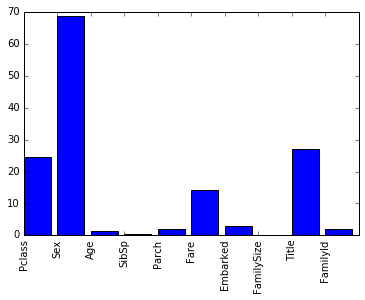

In [24]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]


The final preprocessed dataframe. Now it is ready for training and evaluation:

In [25]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,NameLength,Title,FamilyId
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,0,1,23,1,-1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,1,1,51,3,-1
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,0,0,22,2,-1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,0,1,44,3,-1
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,0,0,24,1,-1


In [26]:
#My routine that encapsulates all the preprocessing work documented above
def preprocess(data):
    data["Age"] = data["Age"].fillna(data["Age"].median())
    data["Fare"] = data["Fare"].fillna(data["Fare"].median())
    data.loc[data["Sex"] == "male", "Sex"] = 0 
    data.loc[data["Sex"] == "female", "Sex"] = 1
    data["Embarked"] = data["Embarked"].fillna("S")

    data.loc[data["Embarked"] == "S", "Embarked"] = 0
    data.loc[data["Embarked"] == "C", "Embarked"] = 1
    data.loc[data["Embarked"] == "Q", "Embarked"] = 2

    # Generating a familysize column
    data["FamilySize"] = data["SibSp"] + data["Parch"]

    # The .apply method generates a new series
    data["NameLength"] = data["Name"].apply(lambda x: len(x))


    import re
    # Get all the titles and print how often each one occurs.
    titles = data["Name"].apply(get_title)
    #     print(pd.value_counts(titles))

    # Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
    for k,v in title_mapping.items():
        titles[titles == k] = v

    # Verify that we converted everything.
    #     print(pd.value_counts(titles))

    # Add in the title column.
    data["Title"] = titles

    import operator

    # A dictionary mapping family name to id
    family_id_mapping = {}

    # Get the family ids with the apply method
    family_ids = data.apply(get_family_id, axis=1)

    # There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
    family_ids[data["FamilySize"] < 3] = -1

    # Print the count of each unique id.
    #     print(pd.value_counts(family_ids))

    data["FamilyId"] = family_ids
    return data


In [27]:
df = titanic = pd.read_csv("data/train.csv")
titanic = preprocess(df)

## Training & Evaluation

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import  grid_search
from sklearn.metrics import classification_report


### Decision Tree

In [29]:
parameters = {'max_depth':range(1,20), 
              'max_features': ["auto", "sqrt", "log2", None]
             }
dtgscv = grid_search.GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, n_jobs=-1)
dtgscv.fit(titanic[predictors], titanic["Survived"])
dtree = dtgscv.best_estimator_

print("Best parameters set found on training set:")
print
print(dtgscv.best_params_)
print("Best parameters set found on training set:")
print
print(dtgscv.best_score_)
print
print("Grid scores on training set:")
print
for params, mean_score, scores in dtgscv.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

Best parameters set found on training set:

{'max_features': None, 'max_depth': 9}
Best parameters set found on training set:

0.842873176207

Grid scores on training set:

0.712 (+/-0.171) for {'max_features': 'auto', 'max_depth': 1}
0.756 (+/-0.141) for {'max_features': 'sqrt', 'max_depth': 1}
0.774 (+/-0.094) for {'max_features': 'log2', 'max_depth': 1}
0.782 (+/-0.066) for {'max_features': None, 'max_depth': 1}
0.777 (+/-0.073) for {'max_features': 'auto', 'max_depth': 2}
0.779 (+/-0.068) for {'max_features': 'sqrt', 'max_depth': 2}
0.777 (+/-0.065) for {'max_features': 'log2', 'max_depth': 2}
0.789 (+/-0.076) for {'max_features': None, 'max_depth': 2}
0.797 (+/-0.082) for {'max_features': 'auto', 'max_depth': 3}
0.783 (+/-0.073) for {'max_features': 'sqrt', 'max_depth': 3}
0.793 (+/-0.068) for {'max_features': 'log2', 'max_depth': 3}
0.825 (+/-0.063) for {'max_features': None, 'max_depth': 3}
0.816 (+/-0.072) for {'max_features': 'auto', 'max_depth': 4}
0.809 (+/-0.080) for {'max_

### Random Forest

#### Parameter Tuning

The first, and easiest, thing we can do to improve the accuracy of the random forest is to increase the number of trees we're using. Training more trees will take more time, but because of the fact that we're averaging many predictions made on different subsets of the data, having more trees will increase accuracy greatly (up to a point).

We can also tweak the min_samples_split and min_samples_leaf variables to reduce overfitting. Because of how a decision tree works (as we explained in the video), having splits that go all the way down, or overly deep in the tree can result in fitting to quirks in the dataset, and not true signal. Thus, increasing min_samples_split and min_samples_leaf can reduce overfitting, which will actually improve our score, as we're making predictions on unseen data. A model that is less overfit, and that can generalize better, will actually perform better on unseen data, but worse on seen data.

In [30]:
# alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

parameters = {
    "n_estimators": [100, 150, 200], 
    "min_samples_split": range(1,10), 
#     "min_samples_leaf": range(1,10)
    }
rff_gscv = grid_search.GridSearchCV(RandomForestClassifier(), parameters, cv=10, n_jobs=-1)
rff_gscv.fit(titanic[predictors], titanic["Survived"])
rfc = rff_gscv.best_estimator_

print("Best parameters set found on training set:")
print
print(rff_gscv.best_params_)
print
print("Best parameters set found on training set:")
print
print(rff_gscv.best_score_)
print
print("Grid scores on training set:")
print
for params, mean_score, scores in rff_gscv.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

Best parameters set found on training set:

{'min_samples_split': 7, 'n_estimators': 150}

Best parameters set found on training set:

0.826038159371

Grid scores on training set:

0.817 (+/-0.059) for {'min_samples_split': 1, 'n_estimators': 100}
0.816 (+/-0.060) for {'min_samples_split': 1, 'n_estimators': 150}
0.818 (+/-0.059) for {'min_samples_split': 1, 'n_estimators': 200}
0.814 (+/-0.070) for {'min_samples_split': 2, 'n_estimators': 100}
0.819 (+/-0.062) for {'min_samples_split': 2, 'n_estimators': 150}
0.817 (+/-0.057) for {'min_samples_split': 2, 'n_estimators': 200}
0.820 (+/-0.060) for {'min_samples_split': 3, 'n_estimators': 100}
0.820 (+/-0.053) for {'min_samples_split': 3, 'n_estimators': 150}
0.822 (+/-0.060) for {'min_samples_split': 3, 'n_estimators': 200}
0.820 (+/-0.059) for {'min_samples_split': 4, 'n_estimators': 100}
0.822 (+/-0.065) for {'min_samples_split': 4, 'n_estimators': 150}
0.819 (+/-0.051) for {'min_samples_split': 4, 'n_estimators': 200}
0.824 (+/-0.057

### Gradient Boosted

Another method that builds on decision trees is a gradient boosting classifier. Boosting involves training decision trees one after another, and feeding the errors from one tree into the next tree. So each tree is building on all the other trees that came before it. This can lead to overfitting if we build too many trees, though. As you get above 100 trees or so, it's very easy to overfit and train to quirks in the dataset. As our dataset is extremely small, we'll limit the tree count to just 25.

Another way to limit overfitting is to limit the depth to which each tree in the gradient boosting process can be built. We'll limit the tree depth to 3 to avoid overfitting.

We'll try boosting instead of our random forest approach and see if we can improve our accuracy.

In [32]:
# alg = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

parameters = {
    "learning_rate": range(1,10), 
    "n_estimators": [ 100, 150], 
    "max_depth": range(1,10)
    }
gbc_gscv = grid_search.GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs = -1)
gbc_gscv.fit(titanic[predictors], titanic["Survived"])
gbc = gbc_gscv.best_estimator_

print("Best parameters set found on training set:")
print
print(gbc_gscv.best_params_)
print("Best parameters set found on training set:")
print
print(gbc_gscv.best_score_)
print
print("Grid scores on training set:")
print
for params, mean_score, scores in gbc_gscv.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))

Best parameters set found on training set:

{'n_estimators': 100, 'learning_rate': 1, 'max_depth': 2}
Best parameters set found on training set:

0.821548821549

Grid scores on training set:

0.815 (+/-0.038) for {'n_estimators': 100, 'learning_rate': 1, 'max_depth': 1}
0.809 (+/-0.033) for {'n_estimators': 150, 'learning_rate': 1, 'max_depth': 1}
0.822 (+/-0.050) for {'n_estimators': 100, 'learning_rate': 1, 'max_depth': 2}
0.817 (+/-0.073) for {'n_estimators': 150, 'learning_rate': 1, 'max_depth': 2}
0.804 (+/-0.063) for {'n_estimators': 100, 'learning_rate': 1, 'max_depth': 3}
0.813 (+/-0.071) for {'n_estimators': 150, 'learning_rate': 1, 'max_depth': 3}
0.802 (+/-0.070) for {'n_estimators': 100, 'learning_rate': 1, 'max_depth': 4}
0.808 (+/-0.066) for {'n_estimators': 150, 'learning_rate': 1, 'max_depth': 4}
0.791 (+/-0.074) for {'n_estimators': 100, 'learning_rate': 1, 'max_depth': 5}
0.796 (+/-0.069) for {'n_estimators': 150, 'learning_rate': 1, 'max_depth': 5}
0.804 (+/-0.064) f

## Kaggle Submission

In [ ]:
test_data = pd.read_csv("data/test.csv")
titanic_test = preprocess(test_data.copy())

models = [dtree, rfc, gbc]

for model in models:
    # Train the algorithm using all the training data
    model.fit(titanic[predictors], titanic["Survived"])

    # Make predictions using the test set.
    predictions = model.predict(titanic_test[predictors])

    # Create a new dataframe with only the columns Kaggle wants from the dataset.
    submission = pd.DataFrame({
            "PassengerId": titanic_test["PassengerId"],
            "Survived": predictions
        })
    submission.to_csv("%s.csv"%model.__class__.__name__, index=False)